# **Emotion Recognition Using MobileNetV3**

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import os
import glob
from tqdm.notebook import tqdm
from PIL import Image
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import cv2
from pandas.core.common import flatten
import random
import copy
from typing import Tuple, Dict, List
import pathlib
from pathlib import Path
import torch.quantization
import time


**Define Dataset Paths**

In [2]:
data_path = Path("./")
image_path = data_path / "./images"


In [3]:
if image_path.is_dir():
    print(f"{image_path} directory exists.")


images directory exists.


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "validation"


**Get Classes**

In [5]:
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")


Target directory: images\train
Class names found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
def find_classes(directory: str): 
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


In [7]:
find_classes(train_dir)


(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

**Build Custom Image Folder**

In [9]:
class ImageFolder_Custom(Dataset):
    
    def __init__(self, targ_dir: str, transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) 
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index: int):
        image_path = self.paths[index]
        return Image.open(image_path) 

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index: int):
        img = self.load_image(index)
       
        #img = cv2.imread(img)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        class_name  = self.paths[index].parent.name 
        class_idx = self.class_to_idx[class_name]

        if self.transform is not None:
            return self.transform(img), class_idx


**Perform Data Augmentation**

In [10]:
train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225]),
])


**Load Datasets**

In [11]:
train_data_custom = ImageFolder_Custom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolder_Custom(targ_dir=test_dir, 
                                     transform=test_transforms)


**Display Random Images**

In [12]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          seed: int = None):
    
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(8, 8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            
        plt.title(title)


In [13]:
class_names = train_data_custom.classes
class_names


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


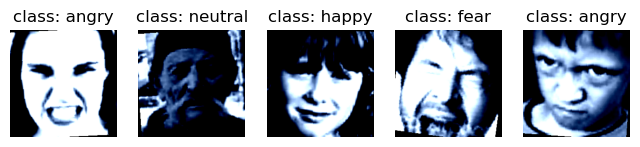

In [14]:
display_random_images(train_data_custom,
                      n = 5,
                      classes=class_names,
                      seed=None)


**Load Data**

In [15]:
train_loader = torch.utils.data.DataLoader(train_data_custom, batch_size=32, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data_custom, batch_size=32, shuffle = False, pin_memory=True)


In [16]:
dataiter = train_loader
images, labels = next(iter(dataiter))


In [17]:
images.shape, labels.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

**Set CUDA**

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [19]:
torch.cuda.is_available()


True

In [20]:
torch.cuda.get_device_name()


'NVIDIA GeForce RTX 3050 Laptop GPU'

**Fine-tune MobileNetV3 Model**

In [21]:
model_ft = models.mobilenet_v3_large(weights="IMAGENET1K_V2",pretrained=True, progress=True)

model_ft.classifier[-1] = nn.Linear(1280, 7)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to C:\Users\amamo/.cache\torch\hub\checkpoints\mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 36.2MB/s]


In [ ]:
#model_ft.features[0][0] = nn.Conv2d(1, model_ft.features[0][0].out_channels, kernel_size=3, stride=2, padding=1, bias=False)


In [22]:
model_ft


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

**Train Model**

In [23]:
def train(net, n_epoch=2):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    best_accuracy = 0
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            y_pred = net(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()


        with torch.no_grad():
            accuracy = []
            for batch in test_loader:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                y_pred = net(x)
                # loss = loss_fn(y_pred, y)
                
                accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
            accuracy = np.mean(np.array(accuracy))
            if accuracy > best_accuracy:
                print('New best model with test acc:', accuracy)
                torch.save(net.state_dict(), './best_model.pt')
                best_accuracy = accuracy

        running_loss += loss.item()
        if i % 500 == 499:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

    print('Обучение закончено')
    return net


In [24]:
model_ft.to(device)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [26]:
train(model_ft, n_epoch=100)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.34334754611903934


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.366994430908458


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.40830577793247474


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.4360207100591716


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.4554255134006265


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.4746562826313957


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.478789592760181


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.4829229028889663


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.49423512008353643


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.495322833275322


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5062869822485208


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5112034458753916


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5130090497737556


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.519404803341455


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5253437173686043


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5274321266968326


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5308584232509572


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5376892620953707


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5397667942916812


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5408545074834668


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5413439784197702


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5463039505743126


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5508614688478942


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5540810998955795


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5552775844065437


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5600526453184824


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5631526279150714


  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5647841977027498


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5666224329968674


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5682866341802993


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5708645144448312


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

New best model with test acc: 0.5747476505395057


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

Обучение закончено


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

**Test Model**

In [27]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model_ft(x)
        # loss = loss_fn(y_pred, y)
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)


Test accuracy 0.5704403063000348


In [28]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        y_pred = model_ft(x)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == y).squeeze()
        for i in range(4):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(7):
    print('Accuracy %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


Accuracy angry : 45 %
Accuracy disgust : 56 %
Accuracy  fear : 39 %
Accuracy happy : 80 %
Accuracy neutral : 50 %
Accuracy   sad : 47 %
Accuracy surprise : 58 %


**Load Model into CPU**

In [29]:
model_ft.to('cpu')


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

**Optimize Model Using Dynamic Quantization**

In [30]:
model_q = torch.quantization.quantize_dynamic(model_ft, {nn.Linear}, dtype = torch.qint8)


In [31]:
print(model_q)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

**Compare Model Sizes**

In [32]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    print("model",'\t', 'Size (MB):', size/1e8)
    os.remove('temp.p')
    return size

f=print_size_of_model(model_ft)
q=print_size_of_model(model_q)


model 	 Size (MB): 0.17032526
model 	 Size (MB): 0.13320762


In [33]:
model_ft.to(device)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

**Check Execution Time**

In [34]:
with torch.no_grad():
    accuracy = []
    start = time.time()
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model_ft(x)
        # loss = loss_fn(y_pred, y)
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
        #s = time.time()
        #elapsed = time.time() - s
    end = time.time()    
    accuracy = np.mean(np.array(accuracy))
   

print('Test accuracy', accuracy)
print("elapsed time (seconds): {0:.5f}".format(end - start))


Test accuracy 0.570581709014967
elapsed time (seconds): 27.09044


In [35]:
model_q.to('cpu')


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [36]:
with torch.no_grad():
    accuracy = []
    start = time.time()
    for batch in test_loader:
        x, y = batch
        x = x.to('cpu')
        y = y.to('cpu')
        y_pred = model_q(x)
        # loss = loss_fn(y_pred, y)
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
        #s = time.time()
        #elapsed = time.time() - s
    end = time.time()    
    accuracy = np.mean(np.array(accuracy))
   

print('Test accuracy', accuracy)
print("elapsed time (seconds): {0:.5f}".format(end - start))


Test accuracy 0.6911873477201531
elapsed time (seconds): 111.23966
